# Modeling and Evaluation

## Objectives

* Fit a cluster model to group similar data

## Inputs

* inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv

## Outputs

* Cluster pipeline
* Train Set
* Cluster Description
* Cluster Silhouette

# Change working directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues'

# Load Data

In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv(f"inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv")
print(df.shape)
df.head(3)

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


# Cluster Pipeline

In [5]:
from sklearn.pipeline import Pipeline

from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt
from feature_engine.selection import DropFeatures
from feature_engine.imputation import  MeanMedianImputer
from feature_engine.imputation import  CategoricalImputer
from feature_engine.imputation import  ArbitraryNumberImputer
from feature_engine.selection import SmartCorrelatedSelection

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans


def PipelineCluster():
    pipeline_base = Pipeline([
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['MasVnrArea', '2ndFlrSF'])),
        ("CategoricalImputer", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1'])),
        ("MeanMedianImputer", MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure','BsmtFinType1','GarageFinish','KitchenQual'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF', 'GarageArea'])),
        ("PowerTransformer", vt.PowerTransformer(variables = ['1stFlrSF','LotArea', 'GrLivArea'], exp=0.5)),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("PCA", PCA(n_components=50, random_state=0)),

        ("model", KMeans(n_clusters=50, random_state=0)),

    ])

    return pipeline_base

# Principal Component Analysis (PCA)

In [6]:
pipeline_cluster = PipelineCluster()
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df)

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'numpy.ndarray'>


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

We will apply PCA separately to the scaled data using CI function

* The 10 components explain 85.35% of the data 



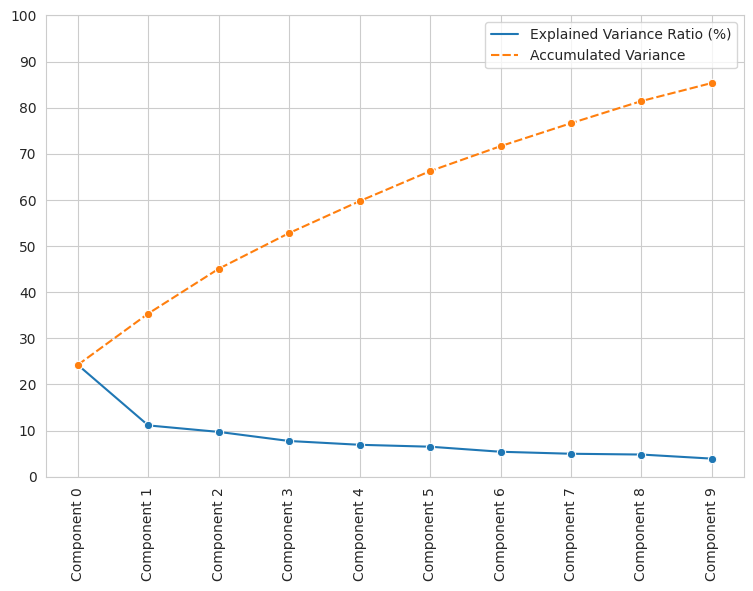

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

n_components = 10


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

We are looking to cover at least 95% of the data, let's increase the components

* The 14 components explain 97.28% of the data 



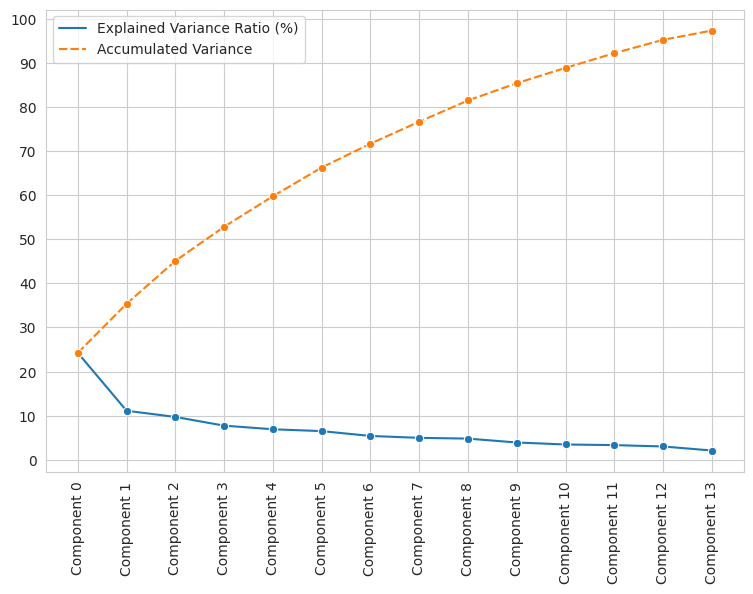

In [8]:
pca_components_analysis(df_pca=df_pca,n_components=14)

Refit the pipeline with the updated components

In [9]:
def PipelineCluster():
    pipeline_base = Pipeline([
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['MasVnrArea', '2ndFlrSF'])),
        ("CategoricalImputer", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1'])),
        ("MeanMedianImputer", MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure','BsmtFinType1','GarageFinish','KitchenQual'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF', 'GarageArea'])),
        ("PowerTransformer", vt.PowerTransformer(variables = ['1stFlrSF','LotArea', 'GrLivArea'], exp=0.5)),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("PCA", PCA(n_components=14, random_state=0)),

        ("model", KMeans(n_clusters=50, random_state=0)),

    ])

    return pipeline_base

In [11]:

pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df)

print(df_analysis.shape,'\n', type(df_analysis))

(1460, 14) 
 <class 'numpy.ndarray'>


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


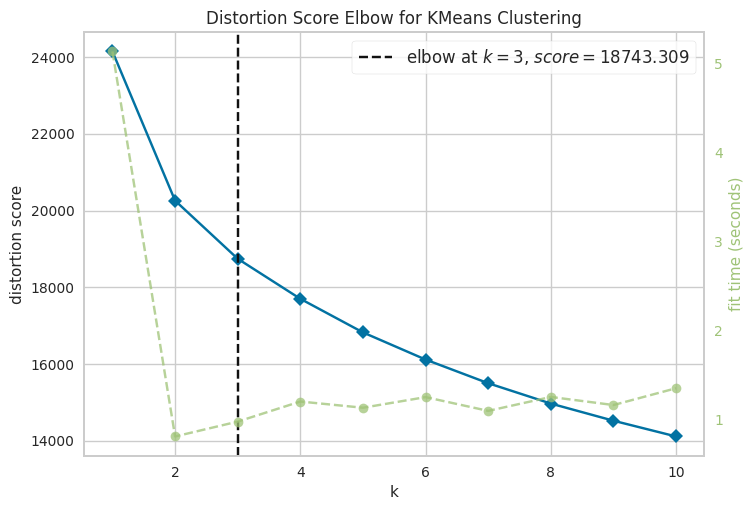

In [12]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11)) # 11 is not inclusive, it will plot until 10
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

=== Average Silhouette Score for different number of clusters ===


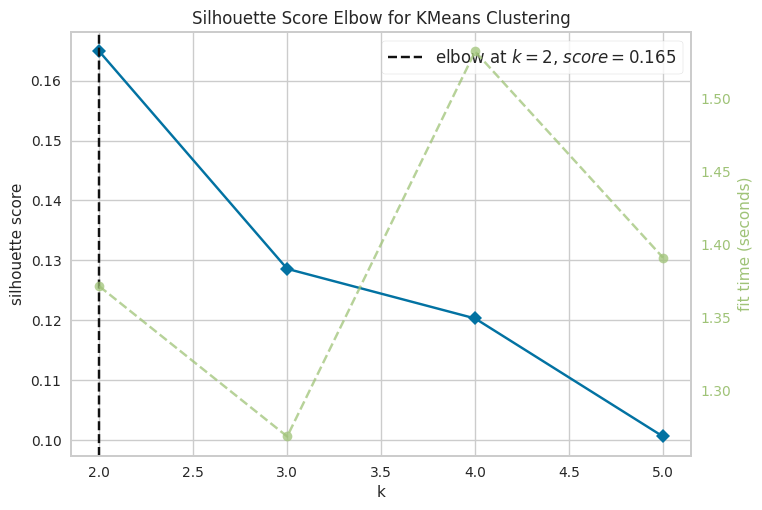



=== Silhouette plot for 2 Clusters ===


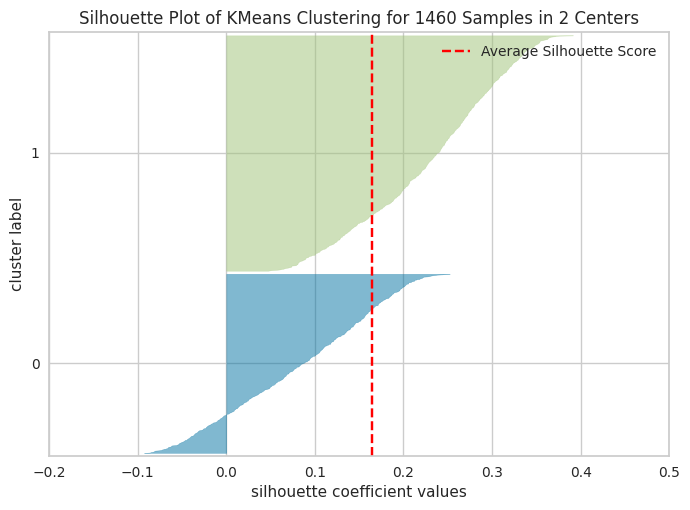



=== Silhouette plot for 3 Clusters ===


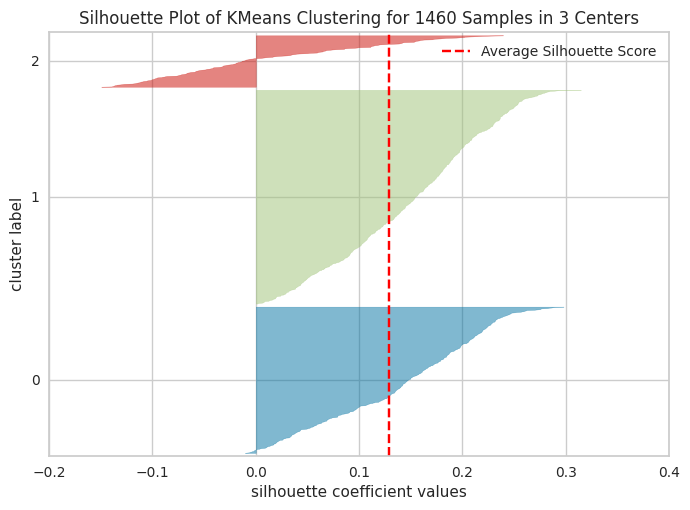



=== Silhouette plot for 4 Clusters ===


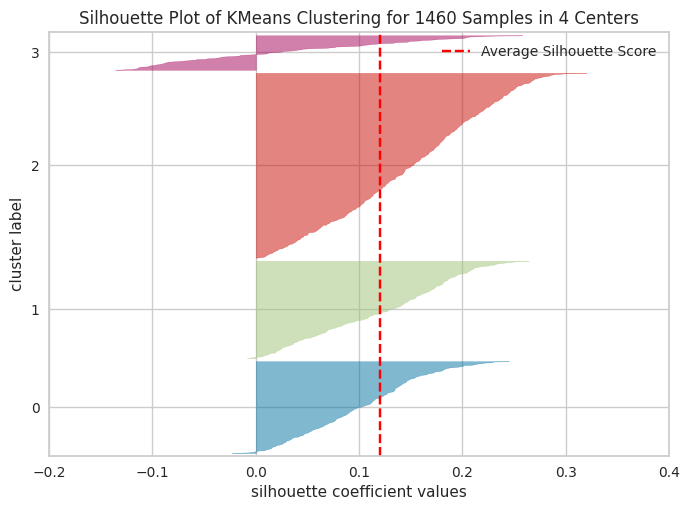



=== Silhouette plot for 5 Clusters ===


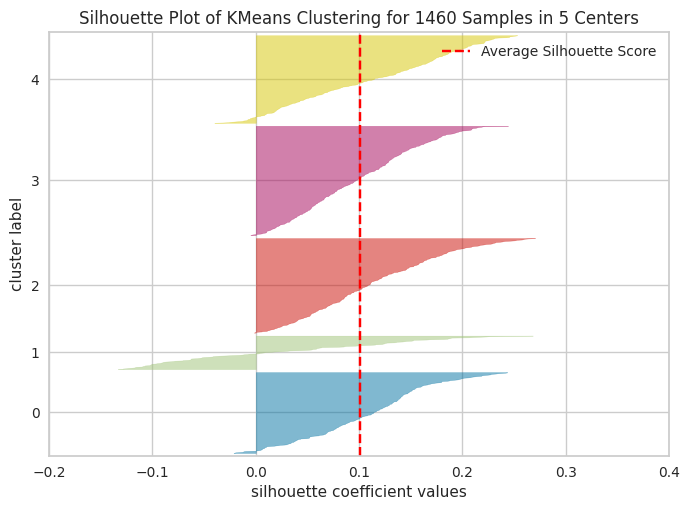

In [13]:
from yellowbrick.cluster import SilhouetteVisualizer

# 6 is not inclusive, it will stop at 5
n_cluster_start, n_cluster_stop = 2, 6

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")

We will pick the most optimal cluster

In [14]:
def PipelineCluster():
    pipeline_base = Pipeline([
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['MasVnrArea', '2ndFlrSF'])),
        ("CategoricalImputer", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1'])),
        ("MeanMedianImputer", MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure','BsmtFinType1','GarageFinish','KitchenQual'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF', 'GarageArea'])),
        ("PowerTransformer", vt.PowerTransformer(variables = ['1stFlrSF','LotArea', 'GrLivArea'], exp=0.5)),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("PCA", PCA(n_components=14, random_state=0)),

        ("model", KMeans(n_clusters=4, random_state=0)),

    ])

    return pipeline_base